<a href="https://colab.research.google.com/github/priyaChaturvedi11/Face_Recognition_Project/blob/master/radhika_check_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import os
#The OS module in Python provides a way of using operating system dependent functionality. 
#The functions that the OS module provides allows you to interface with the underlying operating system that Python is running on – be that Windows, Mac or Linux.

#PyTorch is an open source 
#machine learning library used for developing and training neural network based deep learning models. It is primarily developed by Facebook's AI research group

#Torchvision library, which is a part of Pytorch, contains all the important datasets as well as models and transformation operations
#generally used in the field of computer vision It allows you to import datasets without any hassle.. 
import torchvision

#All datasets are subclasses of torch.utils.data.Dataset i.e, they have __getitem__ and __len__ methods implemented
import torchvision.datasets as dset  

#Transforms are common image transformations
import torchvision.transforms as transforms  

from torch.utils.data import DataLoader,Dataset 
#At the heart of PyTorch data loading utility is the torch.utils.data.DataLoader class. It represents a Python iterable over a dataset, with support for
#DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,batch_sampler=None, num_workers=0, collate_fn=None,pin_memory=False, drop_last=False, timeout=0,worker_init_fn=None)
#The most important argument of DataLoader constructor is dataset, which indicates a dataset object to load data from. PyTorch supports two different types of datasets: 
#1)map-style datasets, 2)iterable-style datasets.
# and we are using map-style datasets ---> Map-style datasets
#A map-style dataset is one that implements the _getitem() and __len_() protocols, and represents a map from (possibly non-integral) indices/keys to data samples.


import matplotlib.pyplot as plt
#matplotlib. pyplot is a collection of command style functions that make matplotlib work like MATLAB.
#Each pyplot function makes some change to a figure:e.g., creates a figure,creates a plotting area in a figure, plots some lines in a plotting area,decorates the plot with labels,etc.


import torchvision.utils
#

import numpy as np
#NumPy is a library for the Python programming language, adding support for large, 
#multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays

import random
#This module implements pseudo-random number generators for various distributions.

from PIL import Image
#Python Imaging Library (abbreviated as PIL) (in newer versions known as Pillow) is a free and open-source additional library for the Python programming language that 
#adds support for opening, manipulating, and saving many different image file formats. It is available for Windows, Mac OS X and Linux.

import torch
#Torch is an open-source machine learning library, a scientific computing framework, and a script language based on the Lua programming language.
# It provides a wide range of algorithms for deep learning, and uses the scripting language LuaJIT, and an underlying C implementation.

from torch.autograd import Variable
#A PyTorch Variable is a wrapper around a PyTorch Tensor, and represents a node in a computational graph.
# If x is a Variable then x.data is a Tensor giving its value, and x.grad is another Variable holding the gradient of x with respect to some scalar value.

#PyTorch Variables have the same API as PyTorch tensors:
#(almost) any operation you can do on a Tensor you can also do on a Variable; the difference is that autograd allows you to automatically compute gradients.

import PIL.ImageOps    
#The ImageOps module contains a number of ‘ready-made’ image processing operations. This module is somewhat experimental, and most operators only work on L(LAB uses the three channels representing “L” (lightness), “a” (Red/Green) and “b” (Blue/Yellow). 
#It sounds like a strange way of working at first, but when you get used to it, it can be quite valuable for correcting or altering colour) and RGB images.
#PIL.ImageOps.autocontrast(image, cutoff=0, ignore=None)
#Maximize (normalize) image contrast. This function calculates a histogram of the input image, removes cutoff percent of the lightest and darkest pixels from the histogram,
# and remaps the image so that the darkest pixel becomes black (0), and the lightest becomes white (255).

import torch.nn as nn
#PyTorch provides the torch. nn module to help us in creating and training of the neural network. 


from torch import optim
#torch-optimizer – collection of optimizers for PyTorch compatible with optim module.
#torch.optim is a package implementing various optimization algorithms. Most commonly used methods are already supported, 
#and the interface is general enough, so that more sophisticated ones can be also easily integrated in the future.

import torch.nn.functional as F
#

## Helper functions
Set of helper functions

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy() #we have tensor---> numpy change tensor to numpy array i.e. required for matplotlib
    plt.axis("off")     #x,y off
    if text:           #if text present on image
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  #current figure create 
    plt.show()          #only show current figure


def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


   

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Configuration Class
A simple class to manage configuration

In [5]:
class Config():
    training_dir = "/content/drive/My Drive/final_dataset_frs/att_training"
    testing_dir = "/content/drive/My Drive/final_dataset_frs/att_testing"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [29]:
class SiameseNetworkDataset(Dataset):
#"__init__" is a reseved method in python classes. It is called as a constructor in object oriented terminology. 
#This method is called when an object is created from a class and it allows the class to initialize the attributes of the class 

#The self in keyword in Python is used to all the instances in a class. By using the self keyword, 
#one can easily access all the instances defined within a class, including its methods and attributes. init. __init__ is one of the reserved methods in Python
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):       ##def __init__(self, [arguments])
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert



#There are getter are implemented by __getitem__() methods. 
#But, these methods are used only in indexed attributes like arrays, dictionaries, lists e.t.c. Instead of directly accessing and manipulating class attributes, 
#it provides such methods, so these attributes can be modified only by its own instances and thus implements abstraction.


    def __getitem__(self,index): 
        img0_tuple = random.choice(self.imageFolderDataset.imgs)   #imageFolderDataset = training path... #img0_tuple =pick anty random image from this path--->whole path
        filename_img0 = img0_tuple[0]       #img0_tuple= (file_name, folder_index)   In filename_img0 we need only File_name i.e. img0_tuple[0] 
        imgname_0 = os.path.split(filename_img0)[1]   #splits like--> ( (drive/my drive/data/training) , (S1_M_1.pgm ) ) and we need only name of image so that we can identify whether it's mask or unmask image
        imgname_0 = imgname_0.split(".")[0]    # In imgname_0 we need only split with extension of image , now  imgname_0=S1_M_1
        
        
        should_get_same_class = random.randint(0,1)        #randomly generate 0,1

        if should_get_same_class:        
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)   #randomly generating second image
                filename_img1 = img1_tuple[0]
                imgname_1 = os.path.split(filename_img1)[1]         #now  imgname_0 = S1_M_1

                if (img0_tuple[1]==img1_tuple[1]):                     #both image belongs to same folder------    img1_tuple[1]= folder_index
                 if(imgname_1.split("_")[1] != imgname_0.split("_")[1]):   #one image mask and another unmask
                  break

        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                filename_img1 = img1_tuple[0]
                imgname_1 = os.path.split(filename_img1)[1]
                imgname_1 = imgname_1.split(".")[0] 

                if(img0_tuple[1] !=img1_tuple[1]):    #both image not belongs to same folder------    img1_tuple[1]= folder_index
                  if(imgname_1.split("_")[1] != imgname_0.split("_")[1]):     #one image mask and another unmask
                    break
                
        img0 = Image.open(img0_tuple[0])    ##img0_tuple= (file_name, folder_index) 
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")   #covert to grayscale--- white and black mode so that we can invert it
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):    #print length of training data
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset


Using Image Folder Dataset
All datasets are subclasses of torch.utils.data.Dataset i.e, they have getitem and len methods implemented import torchvision.datasets as dset

ImageFolder= stack of all images path one over other

torchvision.datasets.ImageFolder(root, transform=None, target_transform=None, loader=, is_valid_file=None)[SOURCE] A generic data loader where the images are arranged in this way:

root/dog/xxx.png root/dog/xxy.png root/dog/xxz.png

root/cat/123.png root/cat/nsdf3.png root/cat/asd932_.png


In [20]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)   #folder_dataset= training data

In [31]:
#class SiameseNetworkDataset(Dataset):
#  def __init__(self,imageFolderDataset,transform=None,should_invert=True): 

# passing these values to class  SiameseNetworkDatase to create custom dataset


siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

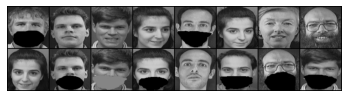

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [32]:
#from torch.utils.data import DataLoader,Dataset 

#DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,batch_sampler=None, num_workers=0, collate_fn=None,pin_memory=False, drop_last=False, timeout=0,worker_init_fn=None)

#PyTorch supports two different types of datasets: 
#1)map-style datasets, 2)iterable-style datasets.
# and we are using map-style datasets ---> Map-style datasets
#A map-style dataset is one that implements the _getitem() and __len_() protocols, and represents a map from (possibly non-integral) indices/keys to data samples.


vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,     #num_workers , which denotes the number of processes that generate batches in parallel
                        batch_size=8)      #batch_size (int, optional) – how many samples per batch to load (default: 1)
dataiter = iter(vis_dataloader)             #iter() function returns an iterator for the given object.

#example_batch= (image0, image1, 0 0r 1 )
example_batch = next(dataiter)  # next() function returns the next item in an iterator

#torch.cat. Concatenates the given sequence of seq tensors ----- example_batch[0]=tensor([[[[0.3765, 0.3922, 0.3922,  ..., 0.4275, 0.4275, 0.4314],
concatenated = torch.cat((example_batch[0],example_batch[1]),0)     #the dimension over which the tensors are concatenated=0


imshow(torchvision.utils.make_grid(concatenated))

print(example_batch[2].numpy())   #prints (0,1) 1 indiciates dissimilar, and 0 indicates similar.

## Neural Net Definition
We will use a standard convolutional neural network

In [33]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [35]:
#The contrastive loss function is used to find the similarity between the image pair. 
#In Siamese network, input pair will be the input, at the output layer the loss will be calculated based on the input pair and backpropagated. 
#Contrastive loss function can be defined as:----   (1-y)(1/2)(Dw)^2+y(1/2){max(0,m-DW)}^2
#where Dw is Euclidean distance, m is the margin and y is the label



#import torch.nn as nn
#PyTorch provides the torch. nn module to help us in creating and training of the neural network. 

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """


  #Margin: defines a radius around the embedding space of samples , so that dissimilar pairs only contribute to contrastive loss Function --- if distance Dw with margin
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()   #super()._init_()  # By running following line, you call the base class
        self.margin = margin


#The forward function computes output Tensors from input Tensors. The backward function receives the gradient of the output Tensors with respect to some scalar value, 
#and computes the gradient of the input Tensors with respect to that same scalar value.

    def forward(self, output1, output2, label):
      #In order to measure how similar two vectors are to each other, we need a way of measuring distance. 
      #In 2 or 3 dimensions the euclidian distance (“ordinary” or straight-line distance) is a great choice for measuring the distance between two points.

      #import torch.nn.functional as F 
      #Tensor torch::nn::functional::pairwise_distance(const Tensor &x1, const Tensor &x2, const PairwiseDistanceFuncOptions &options = {})
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True) 
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [36]:
##from torch.utils.data import DataLoader,Dataset 

#DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,batch_sampler=None, num_workers=0, collate_fn=None,pin_memory=False, drop_last=False, timeout=0,worker_init_fn=None)


train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [37]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [38]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

Epoch number 0
 Current loss 1.4167115688323975

Epoch number 1
 Current loss 4.123938083648682

Epoch number 2
 Current loss 2.1293177604675293

Epoch number 3
 Current loss 1.7778558731079102

Epoch number 4
 Current loss 1.519432544708252

Epoch number 5
 Current loss 0.8913885354995728

Epoch number 6
 Current loss 0.832915186882019

Epoch number 7
 Current loss 0.6920132637023926

Epoch number 8
 Current loss 0.3324328362941742

Epoch number 9
 Current loss 0.3623111844062805

Epoch number 10
 Current loss 0.4543425142765045

Epoch number 11
 Current loss 0.2840571403503418

Epoch number 12
 Current loss 0.3605140447616577

Epoch number 13
 Current loss 0.27771854400634766

Epoch number 14
 Current loss 0.24414879083633423

Epoch number 15
 Current loss 0.18736417591571808

Epoch number 16
 Current loss 0.3307953476905823

Epoch number 17
 Current loss 0.23060601949691772

Epoch number 18
 Current loss 0.2895185351371765

Epoch number 19
 Current loss 0.1121736466884613

Epoch num

In [15]:
#Oneshot learning is like extracting the feature vectors of the input images from
#the trained model to say how much both of the images are dissimilar without training the images of large datasets


def oneshot(model,img1,img2):
       # Gives you the feature vector of both inputs
       output1,output2 = net(img1.cuda(),img2.cuda())
       # Compute the distance 
       euclidean_distance = F.pairwise_distance(output1, output2)
       #with certain threshold of distance say its similar or not
       if euclidean_distance > 0.5:
               print("1:Imposter")
       else:
               print("0:Same Person")
       return euclidean_distance

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

0:Same Person


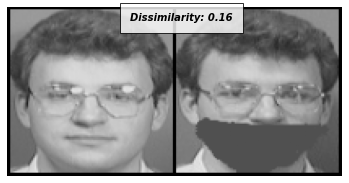

0:Same Person


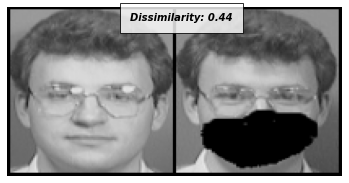

1:Imposter


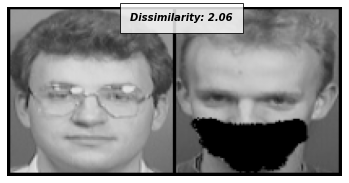

1:Imposter


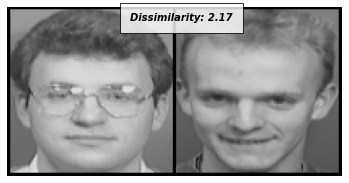

0:Same Person


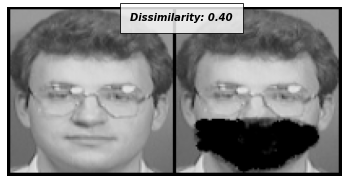

0:Same Person


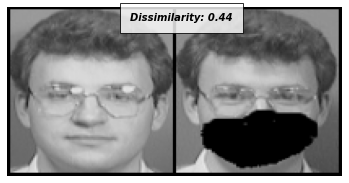

1:Imposter


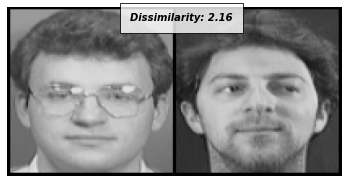

1:Imposter


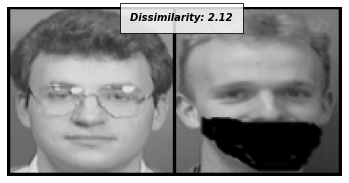

1:Imposter


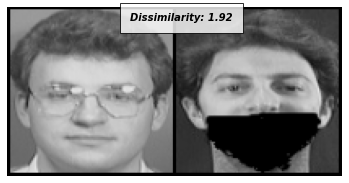

1:Imposter


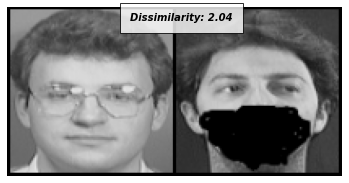

In [18]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    similarity_score = oneshot(net,Variable(x0),Variable(x1)) 
    # output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    # euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(similarity_score.item()))

#RMS optimiser

In [21]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [22]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.268560528755188

Epoch number 1
 Current loss 470.77752685546875

Epoch number 2
 Current loss 24.29155158996582

Epoch number 3
 Current loss 36.63395690917969

Epoch number 4
 Current loss 10.3797025680542

Epoch number 5
 Current loss 6.397690773010254

Epoch number 6
 Current loss 4.520751953125

Epoch number 7
 Current loss 1.3487436771392822

Epoch number 8
 Current loss 1.0609650611877441

Epoch number 9
 Current loss 0.8116925358772278

Epoch number 10
 Current loss 0.8142163753509521

Epoch number 11
 Current loss 0.6728248596191406

Epoch number 12
 Current loss 0.4626544713973999

Epoch number 13
 Current loss 0.5170625448226929

Epoch number 14
 Current loss 0.4423280358314514

Epoch number 15
 Current loss 0.29394108057022095

Epoch number 16
 Current loss 0.37516212463378906

Epoch number 17
 Current loss 0.3469432592391968

Epoch number 18
 Current loss 0.3542000949382782

Epoch number 19
 Current loss 0.26894837617874146

Epoch number 20
 

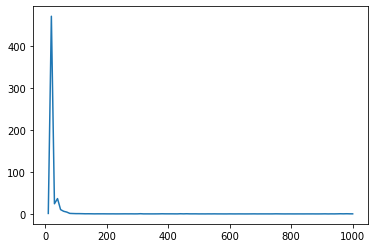

In [23]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [26]:
#Oneshot learning is like extracting the feature vectors of the input images from
#the trained model to say how much both of the images are dissimilar without training the images of large datasets


def oneshot(model,img1,img2):
       # Gives you the feature vector of both inputs
       output1,output2 = net(img1.cuda(),img2.cuda())
       # Compute the distance 
       euclidean_distance = F.pairwise_distance(output1, output2)
       #with certain threshold of distance say its similar or not
       if euclidean_distance > 0.5:
               print("1:Imposter")
       else:
               print("0:Same Person")
       return euclidean_distance

1:Imposter


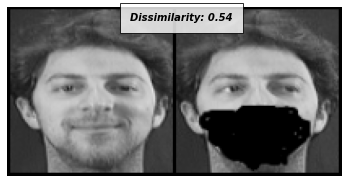

1:Imposter


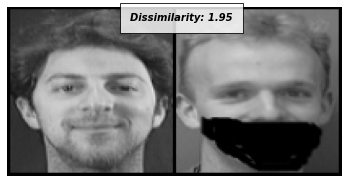

1:Imposter


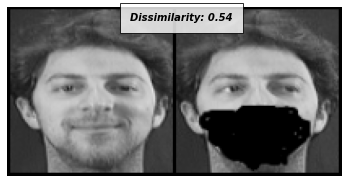

0:Same Person


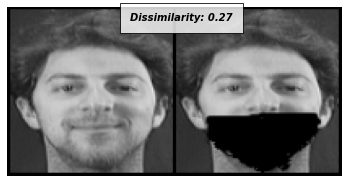

1:Imposter


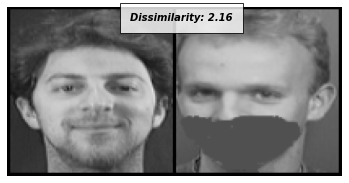

1:Imposter


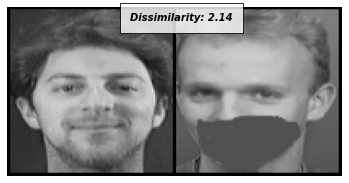

1:Imposter


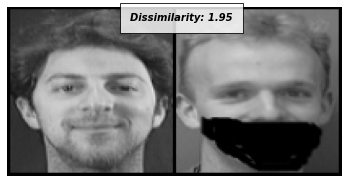

1:Imposter


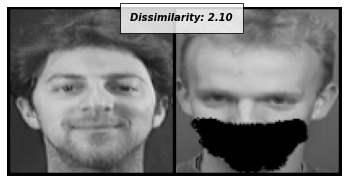

1:Imposter


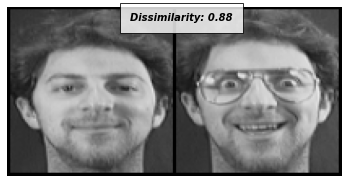

1:Imposter


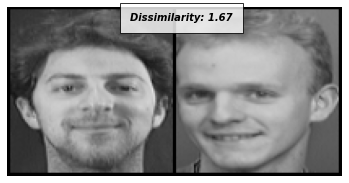

In [27]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    similarity_score = oneshot(net,Variable(x0),Variable(x1)) 
    # output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    # euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(similarity_score.item()))

In [30]:
test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
accuracy=0
counter=0
correct=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
  output1,output2 = net(x0.to(device),x1.to(device))
  res=torch.abs(output1.cuda() - output2.cuda())
  label=label[0].tolist()
  label=int(label[0])
  result=torch.max(res,1)[1][0][0][0].data[0].tolist()
  if label == result:
    correct=correct+1
  counter=counter+1
#   if counter ==20:
#      break
    
accuracy=(correct/len(test_dataloader))*100
print("Accuracy:{}%".format(accuracy))

NameError: ignored

### Second **Training**

ContrastiveLoss:
When ytrue is 1, that means the questions are duplicates of each other, so the Euclidean distance (ypred) between their outputs must be minimized. So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).

When ytrue is 0, i.e. the questions are not duplicates, then the Euclidean distance between them must be maximized, at least to the margin. So the loss to be minimized is the difference of the margin and the Euclidean distance - (margin - y_pred). If the Euclidean distance (ypred) is already greater than the margin, then nothing is to be learned, so the loss is made to be zero in that case by saying K.maximum(margin - y_pred, 0)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))




    

accuracy of Siamese Network ad it will be useful for setting a margin. So, why do you learn the Siamese network? Because you want that features extracted from same class was similar and from different class was dissimilar. So to get an accuracy of such process, you need to create a pair of data points(ex. images) with labels same/not same (balanced data). Then just make a verification test, so find distance of each pair and the threshold which give you best overall accuracy of predicting same/not same pairs. This is how you can get accuracy score of Siamese network.



Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”.
From another side of view ,Neural net able to project any data samples into any hypersphere, so Margin value necessity is only to constrain specific net architecture(projection ability) to specific data distribution to filter outliers.

In [ ]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9379851818084717

Epoch number 1
 Current loss 46.944854736328125

Epoch number 2
 Current loss 46.62836456298828

Epoch number 3
 Current loss 48.055442810058594

Epoch number 4
 Current loss 18.52323341369629

Epoch number 5
 Current loss 13.2130126953125

Epoch number 6
 Current loss 6.776883125305176

Epoch number 7
 Current loss 5.027156352996826

Epoch number 8
 Current loss 9.152721405029297

Epoch number 9
 Current loss 6.4634904861450195

Epoch number 10
 Current loss 2.8503732681274414

Epoch number 11
 Current loss 3.5130529403686523

Epoch number 12
 Current loss 4.185122013092041

Epoch number 13
 Current loss 3.068850517272949

Epoch number 14
 Current loss 2.868976593017578

Epoch number 15
 Current loss 2.355984687805176

Epoch number 16
 Current loss 1.629328727722168

Epoch number 17
 Current loss 1.8027324676513672

Epoch number 18
 Current loss 3.1390604972839355

Epoch number 19
 Current loss 2.213954210281372

Epoch number 20
 Curren

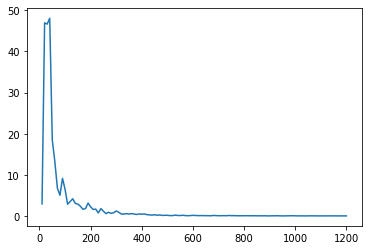

In [ ]:
for epoch in range(0, 120):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [ ]:
##testing

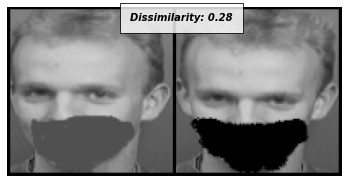

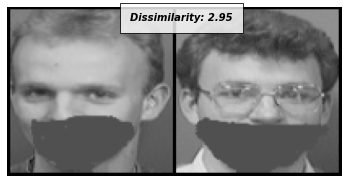

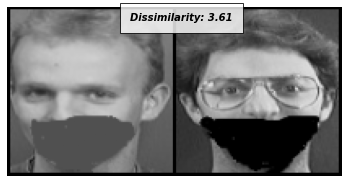

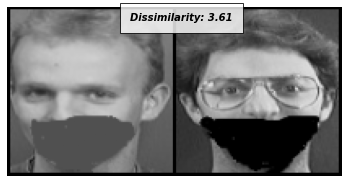

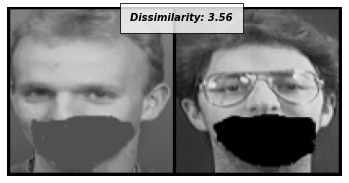

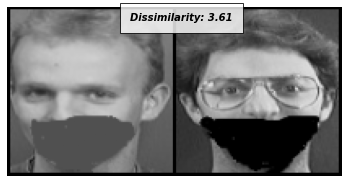

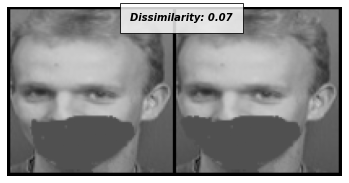

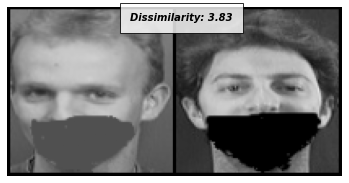

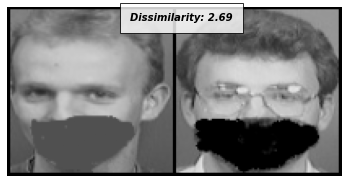

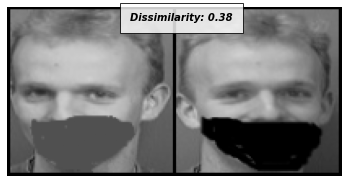

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



# Third Training

ContrastiveLoss:
When ytrue is 1, that means the questions are duplicates of each other, so the Euclidean distance (ypred) between their outputs must be minimized. So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).

When ytrue is 0, i.e. the questions are not duplicates, then the Euclidean distance between them must be maximized, at least to the margin. So the loss to be minimized is the difference of the margin and the Euclidean distance - (margin - y_pred). If the Euclidean distance (ypred) is already greater than the margin, then nothing is to be learned, so the loss is made to be zero in that case by saying K.maximum(margin - y_pred, 0)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))




    

accuracy of Siamese Network ad it will be useful for setting a margin. So, why do you learn the Siamese network? Because you want that features extracted from same class was similar and from different class was dissimilar. So to get an accuracy of such process, you need to create a pair of data points(ex. images) with labels same/not same (balanced data). Then just make a verification test, so find distance of each pair and the threshold which give you best overall accuracy of predicting same/not same pairs. This is how you can get accuracy score of Siamese network.



Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”.
From another side of view ,Neural net able to project any data samples into any hypersphere, so Margin value necessity is only to constrain specific net architecture(projection ability) to specific data distribution to filter outliers.

In [ ]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9379851818084717

Epoch number 1
 Current loss 46.944854736328125

Epoch number 2
 Current loss 46.62836456298828

Epoch number 3
 Current loss 48.055442810058594

Epoch number 4
 Current loss 18.52323341369629

Epoch number 5
 Current loss 13.2130126953125

Epoch number 6
 Current loss 6.776883125305176

Epoch number 7
 Current loss 5.027156352996826

Epoch number 8
 Current loss 9.152721405029297

Epoch number 9
 Current loss 6.4634904861450195

Epoch number 10
 Current loss 2.8503732681274414

Epoch number 11
 Current loss 3.5130529403686523

Epoch number 12
 Current loss 4.185122013092041

Epoch number 13
 Current loss 3.068850517272949

Epoch number 14
 Current loss 2.868976593017578

Epoch number 15
 Current loss 2.355984687805176

Epoch number 16
 Current loss 1.629328727722168

Epoch number 17
 Current loss 1.8027324676513672

Epoch number 18
 Current loss 3.1390604972839355

Epoch number 19
 Current loss 2.213954210281372

Epoch number 20
 Curren

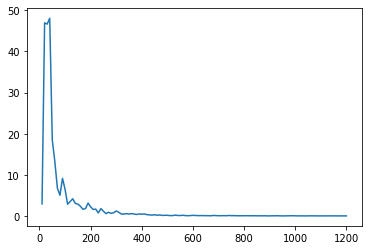

In [ ]:
for epoch in range(0, 120):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

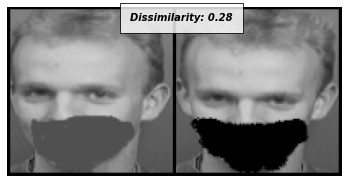

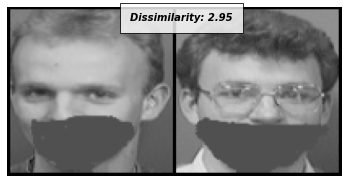

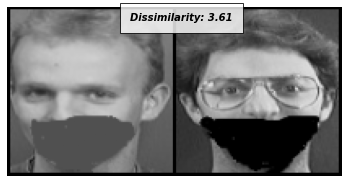

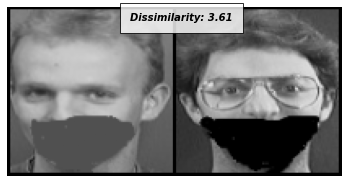

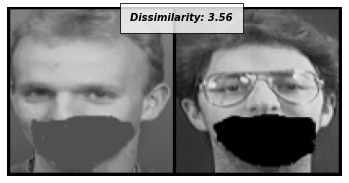

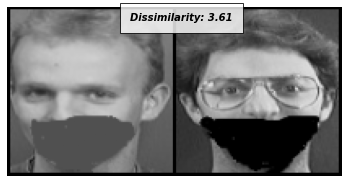

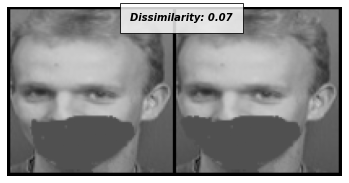

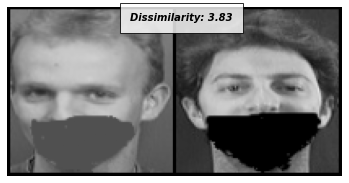

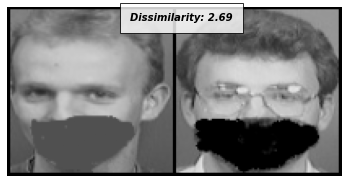

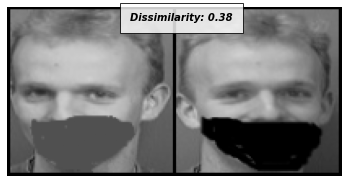

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



## Fourth Training

ContrastiveLoss:
When ytrue is 1, that means the questions are duplicates of each other, so the Euclidean distance (ypred) between their outputs must be minimized. So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).

When ytrue is 0, i.e. the questions are not duplicates, then the Euclidean distance between them must be maximized, at least to the margin. So the loss to be minimized is the difference of the margin and the Euclidean distance - (margin - y_pred). If the Euclidean distance (ypred) is already greater than the margin, then nothing is to be learned, so the loss is made to be zero in that case by saying K.maximum(margin - y_pred, 0)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))




    

accuracy of Siamese Network ad it will be useful for setting a margin. So, why do you learn the Siamese network? Because you want that features extracted from same class was similar and from different class was dissimilar. So to get an accuracy of such process, you need to create a pair of data points(ex. images) with labels same/not same (balanced data). Then just make a verification test, so find distance of each pair and the threshold which give you best overall accuracy of predicting same/not same pairs. This is how you can get accuracy score of Siamese network.



Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”.
From another side of view ,Neural net able to project any data samples into any hypersphere, so Margin value necessity is only to constrain specific net architecture(projection ability) to specific data distribution to filter outliers.

In [ ]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9379851818084717

Epoch number 1
 Current loss 46.944854736328125

Epoch number 2
 Current loss 46.62836456298828

Epoch number 3
 Current loss 48.055442810058594

Epoch number 4
 Current loss 18.52323341369629

Epoch number 5
 Current loss 13.2130126953125

Epoch number 6
 Current loss 6.776883125305176

Epoch number 7
 Current loss 5.027156352996826

Epoch number 8
 Current loss 9.152721405029297

Epoch number 9
 Current loss 6.4634904861450195

Epoch number 10
 Current loss 2.8503732681274414

Epoch number 11
 Current loss 3.5130529403686523

Epoch number 12
 Current loss 4.185122013092041

Epoch number 13
 Current loss 3.068850517272949

Epoch number 14
 Current loss 2.868976593017578

Epoch number 15
 Current loss 2.355984687805176

Epoch number 16
 Current loss 1.629328727722168

Epoch number 17
 Current loss 1.8027324676513672

Epoch number 18
 Current loss 3.1390604972839355

Epoch number 19
 Current loss 2.213954210281372

Epoch number 20
 Curren

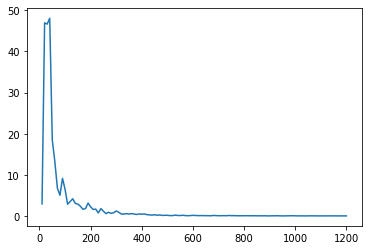

In [ ]:
for epoch in range(0, 120):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

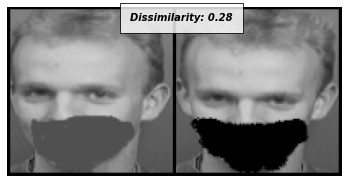

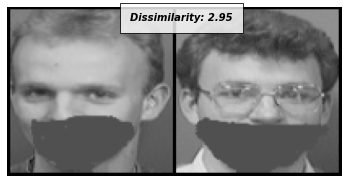

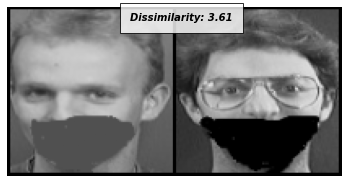

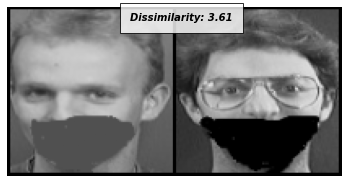

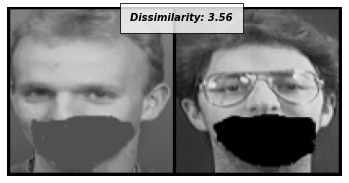

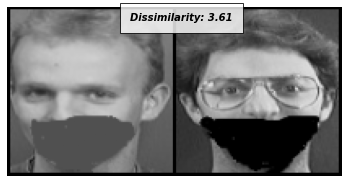

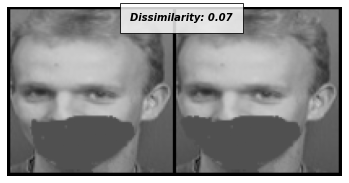

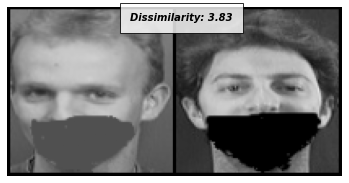

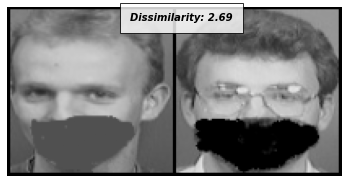

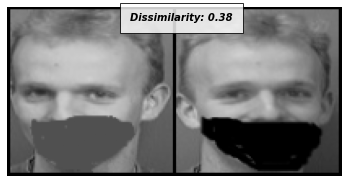

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



### Fifth Training

ContrastiveLoss:
When ytrue is 1, that means the questions are duplicates of each other, so the Euclidean distance (ypred) between their outputs must be minimized. So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).

When ytrue is 0, i.e. the questions are not duplicates, then the Euclidean distance between them must be maximized, at least to the margin. So the loss to be minimized is the difference of the margin and the Euclidean distance - (margin - y_pred). If the Euclidean distance (ypred) is already greater than the margin, then nothing is to be learned, so the loss is made to be zero in that case by saying K.maximum(margin - y_pred, 0)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))




    

accuracy of Siamese Network ad it will be useful for setting a margin. So, why do you learn the Siamese network? Because you want that features extracted from same class was similar and from different class was dissimilar. So to get an accuracy of such process, you need to create a pair of data points(ex. images) with labels same/not same (balanced data). Then just make a verification test, so find distance of each pair and the threshold which give you best overall accuracy of predicting same/not same pairs. This is how you can get accuracy score of Siamese network.



Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”.
From another side of view ,Neural net able to project any data samples into any hypersphere, so Margin value necessity is only to constrain specific net architecture(projection ability) to specific data distribution to filter outliers.

In [ ]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9379851818084717

Epoch number 1
 Current loss 46.944854736328125

Epoch number 2
 Current loss 46.62836456298828

Epoch number 3
 Current loss 48.055442810058594

Epoch number 4
 Current loss 18.52323341369629

Epoch number 5
 Current loss 13.2130126953125

Epoch number 6
 Current loss 6.776883125305176

Epoch number 7
 Current loss 5.027156352996826

Epoch number 8
 Current loss 9.152721405029297

Epoch number 9
 Current loss 6.4634904861450195

Epoch number 10
 Current loss 2.8503732681274414

Epoch number 11
 Current loss 3.5130529403686523

Epoch number 12
 Current loss 4.185122013092041

Epoch number 13
 Current loss 3.068850517272949

Epoch number 14
 Current loss 2.868976593017578

Epoch number 15
 Current loss 2.355984687805176

Epoch number 16
 Current loss 1.629328727722168

Epoch number 17
 Current loss 1.8027324676513672

Epoch number 18
 Current loss 3.1390604972839355

Epoch number 19
 Current loss 2.213954210281372

Epoch number 20
 Curren

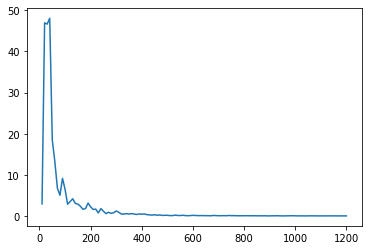

In [ ]:
for epoch in range(0, 120):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

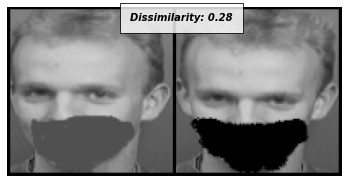

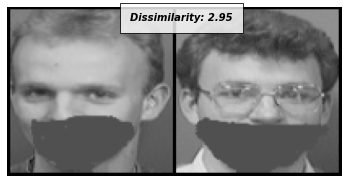

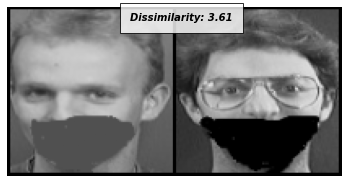

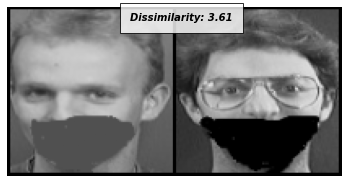

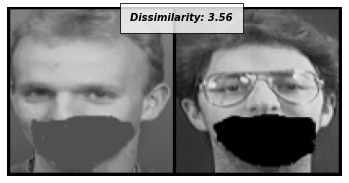

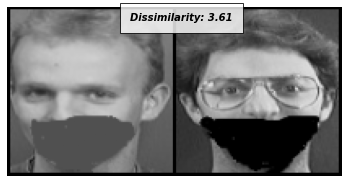

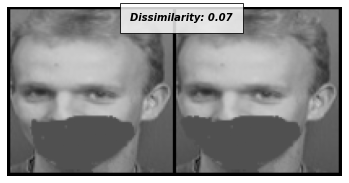

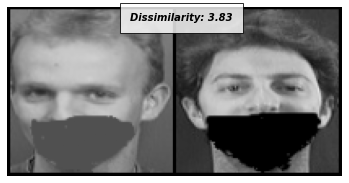

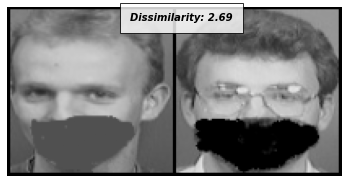

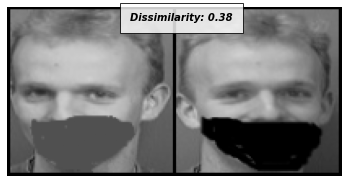

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



## Sixth Training

ContrastiveLoss:
When ytrue is 1, that means the questions are duplicates of each other, so the Euclidean distance (ypred) between their outputs must be minimized. So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).

When ytrue is 0, i.e. the questions are not duplicates, then the Euclidean distance between them must be maximized, at least to the margin. So the loss to be minimized is the difference of the margin and the Euclidean distance - (margin - y_pred). If the Euclidean distance (ypred) is already greater than the margin, then nothing is to be learned, so the loss is made to be zero in that case by saying K.maximum(margin - y_pred, 0)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))




    

accuracy of Siamese Network ad it will be useful for setting a margin. So, why do you learn the Siamese network? Because you want that features extracted from same class was similar and from different class was dissimilar. So to get an accuracy of such process, you need to create a pair of data points(ex. images) with labels same/not same (balanced data). Then just make a verification test, so find distance of each pair and the threshold which give you best overall accuracy of predicting same/not same pairs. This is how you can get accuracy score of Siamese network.



Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”.
From another side of view ,Neural net able to project any data samples into any hypersphere, so Margin value necessity is only to constrain specific net architecture(projection ability) to specific data distribution to filter outliers.

In [ ]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9379851818084717

Epoch number 1
 Current loss 46.944854736328125

Epoch number 2
 Current loss 46.62836456298828

Epoch number 3
 Current loss 48.055442810058594

Epoch number 4
 Current loss 18.52323341369629

Epoch number 5
 Current loss 13.2130126953125

Epoch number 6
 Current loss 6.776883125305176

Epoch number 7
 Current loss 5.027156352996826

Epoch number 8
 Current loss 9.152721405029297

Epoch number 9
 Current loss 6.4634904861450195

Epoch number 10
 Current loss 2.8503732681274414

Epoch number 11
 Current loss 3.5130529403686523

Epoch number 12
 Current loss 4.185122013092041

Epoch number 13
 Current loss 3.068850517272949

Epoch number 14
 Current loss 2.868976593017578

Epoch number 15
 Current loss 2.355984687805176

Epoch number 16
 Current loss 1.629328727722168

Epoch number 17
 Current loss 1.8027324676513672

Epoch number 18
 Current loss 3.1390604972839355

Epoch number 19
 Current loss 2.213954210281372

Epoch number 20
 Curren

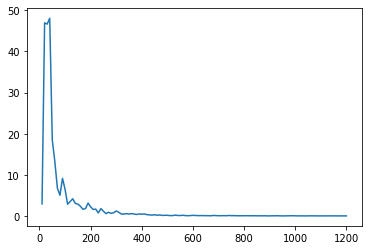

In [ ]:
for epoch in range(0, 120):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

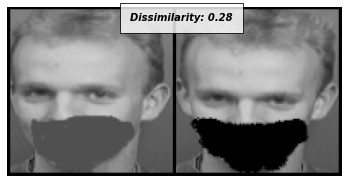

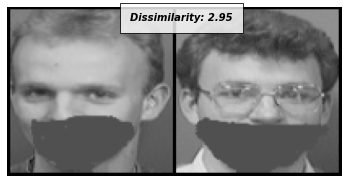

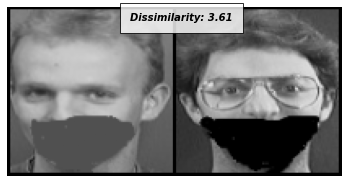

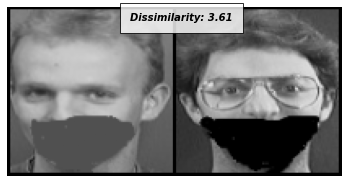

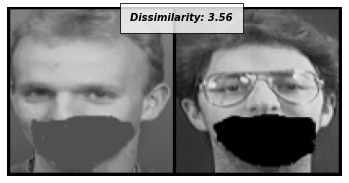

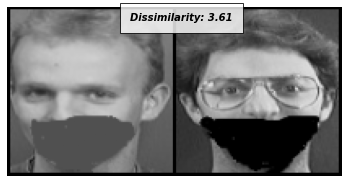

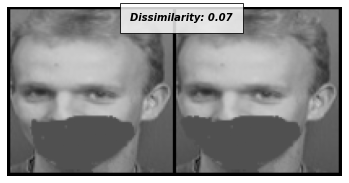

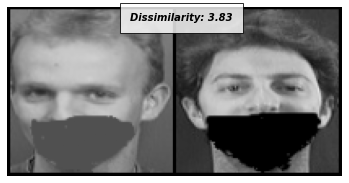

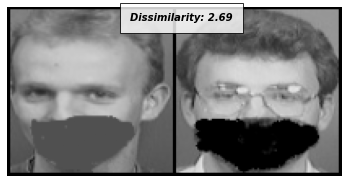

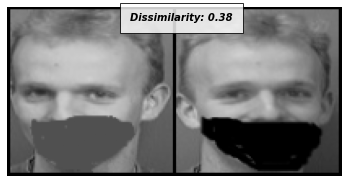

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

